In [41]:
import sys
sys.path.append("../")

In [42]:
from pathlib import Path
# import numpy as np
import jax.numpy as np
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')
halos = np.load(data_dir / 'train_halos.npy')

n_nodes = 5000
halos =  halos[:, :n_nodes, :]

halos_test = np.load(data_dir / 'test_halos.npy')
halos_test =  halos_test[:, :n_nodes, :]

## Prepare data

In [44]:
cosmology = pd.read_csv(data_dir / f'train_cosmology.csv')
cosmology_test = pd.read_csv(data_dir / f'test_cosmology.csv')
print(len(cosmology))

1600


In [45]:
cosmology.head(3)

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187


In [46]:
omega_m = np.array(cosmology['Omega_m'].values)[:,None]
omega_m_test = np.array(cosmology_test['Omega_m'].values)[:,None]

## Train EGNN

In [47]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [48]:
import sys
sys.path.append("../../")
from models.utils.equivariant_graph_utils import get_equivariant_graph
from models.utils.graph_utils import build_graph
from models.utils.irreps_utils import weight_balanced_irreps
from models.segnn import SEGNN

In [49]:
n_feat = 3

halo_pos_mean = halos[..., :n_feat].mean((0,1))
halo_pos_std = halos[..., :n_feat].std((0,1))

In [50]:
halo_pos = (halos[..., :n_feat] - halo_pos_mean)  / halo_pos_std
halo_pos_test = (halos_test[..., :n_feat] - halo_pos_mean)  / halo_pos_std

In [170]:
import e3nn_jax as e3nn
from typing import Dict

SEGNN_PARAMS = {
    "d_hidden": 64,
    "l_max_hidden": 1,
    "num_blocks": 2,
    "num_message_passing_steps": 3,
    "intermediate_hidden_irreps": True,
    "task": "graph",
    "output_irreps": e3nn.Irreps("1x0e"),
    "hidden_irreps": weight_balanced_irreps(lmax=1,
                                            scalar_units=64,
                                            irreps_right=e3nn.Irreps.spherical_harmonics(1),
                                            ),
    "normalize_messages": False,
    "message_passing_agg": "mean",
    "readout_agg": "mean",
}

class GraphWrapper(nn.Module):
    param_dict: Dict
    norm_dict: Dict
    
    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
            velocities = None
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
            velocities = e3nn.IrrepsArray("1o", x.nodes[..., 3:6])

        # print(nodes)
        
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=None,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=1,
            periodic_boundaries=False,
            norm_dict = self.norm_dict,
            unit_cell = np.array([[1.,0.,0.,],[0.,1.,0.], [0.,0.,1.]])
        )
        
        return jax.vmap(SEGNN(**self.param_dict))(st_graph)

In [171]:
graph = build_graph(halo_pos[:2], 
                None, 
                k=20, 
                use_pbc=False, 
                use_edges=True, 
                use_rbf=False, 
                mean=halo_pos_mean, 
                std=halo_pos_std)

norm_dict = {'mean': halo_pos_mean, 'std': halo_pos_std}
model = GraphWrapper(SEGNN_PARAMS, norm_dict)

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)
sum(x.size for x in jax.tree_util.tree_leaves(params))

121985

In [172]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [173]:
# Define train state and replicate across devices
tx = optax.adamw(learning_rate=6e-4, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [174]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [175]:
def loss_mse(pred_batch, cosmo_batch,):
    return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    # # Build graph
    # halo_graph = build_graph(halo_batch, k=k, use_pbc=use_pbc, use_edges=use_edges)

    halo_graph = build_graph(halo_batch, 
                None, 
                k=20, 
                use_pbc=False, 
                use_edges=True, 
                use_rbf=False, 
                mean=halo_pos_mean, 
                std=halo_pos_std)
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [176]:
n_steps = 2000
n_batch = 8
n_train = 1800 

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, halo_pos.shape[0], shape=(n_batch,))
        
        # halo_batch, cosmo_batch = halo_pos[:n_train][idx], omega_m[:n_train][idx]
        halo_batch, cosmo_batch = halo_pos[:n_batch], omega_m[:n_batch]  # Overfit on a small sample

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:45<00:00, 19.03it/s, loss=0.0105201565]


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Text(0, 0.5, 'Predicted')

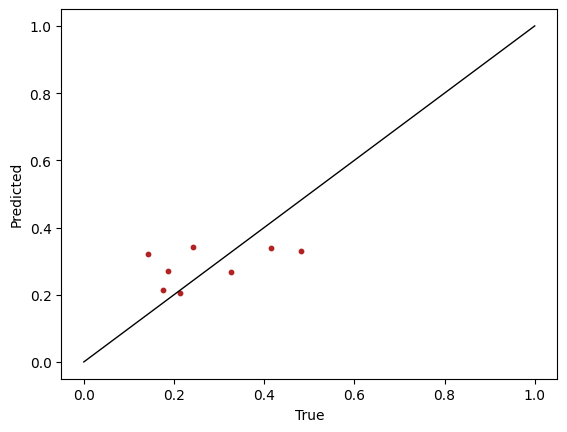

In [177]:
from tqdm import tqdm

n_test_batch = 8

for i in tqdm(range(1)):

    # TODO: jit/pmap
    graph = build_graph(halo_pos[i * n_test_batch:(i + 1) * n_test_batch], 
                        None, 
                        k=20, 
                        use_pbc=False, 
                        use_edges=True, 
                        use_rbf=False, 
                        mean=halo_pos_mean, 
                        std=halo_pos_std
                        )
    
    omega_m_pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    plt.scatter(omega_m[i * n_test_batch:(i + 1) * n_test_batch], omega_m_pred[:, 0], s=10, color='firebrick')
    
# Plot a diagonal (y=x) line
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1)

plt.xlabel("True")
plt.ylabel("Predicted")

100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Text(0, 0.5, 'Predicted')

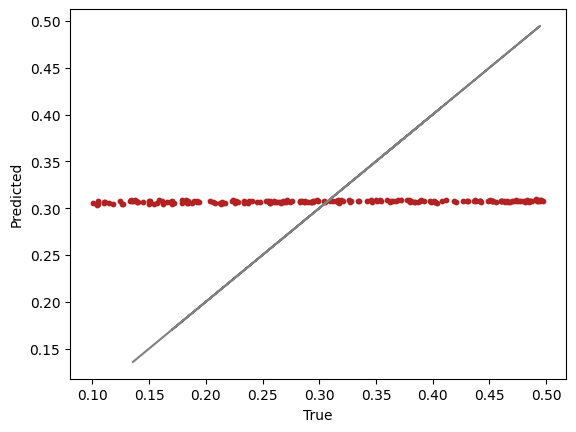

In [65]:
from tqdm import tqdm

n_test_batch = 10
n_test_batches = len(halo_pos_test) // n_test_batch

for i in tqdm(range(n_test_batches)):

    # TODO: jit/pmap
    graph = build_graph(halo_pos_test[i * n_test_batch:(i + 1) * n_test_batch], 
                        None, 
                        k=20, 
                        use_pbc=True, 
                        use_edges=True, 
                        use_rbf=False, 
                        mean=halo_pos_mean, 
                        std=halo_pos_std
                        )
    
    omega_m_pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    plt.scatter(omega_m_test[i * n_test_batch:(i + 1) * n_test_batch], omega_m_pred[:, 0], s=10, color='firebrick')
    
plt.plot(omega_m_test[:n_test_batch], omega_m_test[:n_test_batch], color='gray')

plt.xlabel("True")
plt.ylabel("Predicted")